In [ ]:
from pathlib import Path
import numpy as np

# Project root (GNN-for-Grain-Track)
PROJECT_ROOT = Path.cwd().parent

Functions to read data from for_ML_quaternion_perMatpoint_pergrain.txt files

In [22]:
from pathlib import Path
import numpy as np
import re

def _read_bracket_array(lines, start_idx):
    """
    Reads one numpy-style bracket array that may span multiple lines.
    Returns (array, next_idx).
    """
    s = lines[start_idx].strip()
    if not s.startswith("["):
        raise ValueError(f"Expected '[' at line {start_idx}: {s[:80]}")

    # Accumulate until we see a closing bracket
    while not s.strip().endswith("]"):
        start_idx += 1
        if start_idx >= len(lines):
            raise ValueError("Unexpected EOF while reading a bracket array.")
        s += " " + lines[start_idx].strip()

    # Now s is like: "[ ... ]"
    content = s.strip()[1:-1]
    arr = np.fromstring(content, sep=" ")
    return arr, start_idx + 1


def read_increment_component_arrays_multiline(path: Path):
    with open(path, "r") as f:
        raw_lines = [ln.rstrip("\n") for ln in f if ln.strip()]

    # find first increment line
    inc_start = next((i for i, ln in enumerate(raw_lines) if ln.strip().startswith("increment_")), None)
    if inc_start is None:
        raise ValueError("No 'increment_' blocks found.")

    # header -> component names (exclude 'inc')
    header = [h.strip() for h in raw_lines[:inc_start]]
    components = [h for h in header if h != "inc"]
    n_comp = len(components)
    if n_comp == 0:
        raise ValueError("No components found in header.")

    incs = []
    blocks = []

    i = inc_start
    while i < len(raw_lines):
        ln = raw_lines[i].strip()
        if not ln.startswith("increment_"):
            i += 1
            continue

        m = re.match(r"increment_(\d+)", ln)
        if not m:
            raise ValueError(f"Bad increment line: {ln}")
        inc = int(m.group(1))
        i += 1  # move to first array after increment line

        block = []
        for _ in range(n_comp):
            arr, i = _read_bracket_array(raw_lines, i)  # i advances past the array
            block.append(arr)

        block = np.vstack(block)  # (n_comp, n_matpoints)
        incs.append(inc)
        blocks.append(block)

    incs = np.array(incs, dtype=int)
    arr = np.stack(blocks, axis=0)  # (n_increments, n_comp, n_matpoints)
    return components, incs, arr


Functions for calculating mean quaternion

In [67]:
def normalize_quat(q, axis=-1, eps=1e-12):
    q = np.asarray(q, dtype=float)
    n = np.linalg.norm(q, axis=axis, keepdims=True)
    return q / np.maximum(n, eps)

def misorientation_to_mean_single(Q_mp, q_mean):
    """
    Q_mp: (n_mp, 4)  material-point quaternions (not necessarily normalized)
    q_mean: (4,)     mean quaternion (not necessarily normalized)

    Returns
    -------
    theta: (n_mp,) in radians, sign-safe via abs(dot)
    """
    Qn = normalize_quat(Q_mp, axis=1)         # (n_mp,4)
    qm = normalize_quat(q_mean, axis=0).ravel()  # (4,)
    dot = np.abs(Qn @ qm)                    # (n_mp,)
    dot = np.clip(dot, -1.0, 1.0)
    return 2.0 * np.arccos(dot)

def mean_quaternion_over_matpoints_sum(Q, max_iter=10, tol=1e-10):
    """
    Q: (n_increments, 4, n_matpoints)
    returns q_mean: (n_increments, 4)
    """
    n_inc = Q.shape[0]
    q_mean = np.zeros((n_inc, 4), dtype=float)

    for t in range(n_inc):
        Q_mp = normalize_quat(Q[t].T, axis=-1)  # (n_mp,4)
        # q_ref = Q_mp[0].copy()
        q_ref = np.array([1.0, 0.0, 0.0, 0.0])  # identity

        q_old = None
        for _ in range(max_iter):
            # Compute dot products q^k · q_ref. If dot < 0, flip q^k -> -q^k.
            dots = Q_mp @ q_ref
            Q_aligned = Q_mp.copy()
            Q_aligned[dots < 0] *= -1.0     # enforce consistent sign

            s = Q_aligned.sum(axis=0)       # ∑_k q^k
            q_new = s / np.linalg.norm(s)   # enforce ||q^M||=1

            # compare q_new to q_old, but because q and -q represent the same rotation,
            # we check both distances and take the smaller.
            if q_old is not None:
                if min(np.linalg.norm(q_new - q_old), np.linalg.norm(q_new + q_old)) < tol:
                    break
            
            # theta_deg = np.degrees(misorientation_to_mean_single(Q_mp, q_new))
            # print("mean(deg) =", theta_deg.mean(), "max(deg) =", theta_deg.max())

            # Update for next iteration: using the current mean as the new reference
            q_old = q_new
            q_ref = q_new

        q_mean[t] = q_new   # store mean quaternion for increment t

        # keep consistent sign across increments
        if t > 0 and np.dot(q_mean[t], q_mean[t-1]) < 0:
            q_mean[t] *= -1.0

    # print(t)
    return q_mean

Plot comparison with mean quaternion with material point quaternions

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quats_increment(Q, qM, inc=0, align_to='mean', show_mean=True, figsize=(10, 6)):
    """
    Plot quaternion components for all material points at a chosen increment,
    with optional sign alignment to avoid misleading flips.

    Parameters
    ----------
    Q : array, shape (n_inc, 4, n_mp)
    qM : array, shape (n_inc, 4)
    inc : int
        Increment index to plot.
    align_to : {'mean', 'first', None}
        - 'mean': flip each q_i so dot(q_i, q_mean) >= 0  (recommended)
        - 'first': flip each q_i so dot(q_i, q_first_mp) >= 0
        - None: no alignment (not recommended if sign flips exist)
    show_mean : bool
        Plot mean quaternion as a horizontal line for each component.
    """
    Q_inc = normalize_quat(Q[inc].T, axis=1)   # (n_mp, 4)
    q_mean = normalize_quat(qM[inc], axis=0).reshape(4,)  # (4,)

    if align_to == 'mean':
        ref = q_mean
    elif align_to == 'first':
        ref = Q_inc[0]
    elif align_to is None:
        ref = None
    else:
        raise ValueError("align_to must be one of {'mean','first',None}")

    if ref is not None:
        dots = Q_inc @ ref
        Q_plot = Q_inc.copy()
        Q_plot[dots < 0] *= -1.0
        # also align mean to the same hemisphere as ref for visual consistency
        if np.dot(q_mean, ref) < 0:
            q_mean = -q_mean
    else:
        Q_plot = Q_inc

    mp = np.arange(Q_plot.shape[0])
    labels = ['w', 'x', 'y', 'z']

    plt.figure(figsize=figsize)
    for k in range(4):
        plt.plot(mp, Q_plot[:, k], marker='o', linewidth=1, label=f'mp {labels[k]}')

        if show_mean:
            plt.axhline(q_mean[k], linewidth=1)

    plt.xlabel("Material point index")
    plt.ylabel("Quaternion component value")
    plt.title(f"Increment {inc}: material-point quaternions (aligned_to={align_to})")
    plt.grid(True, alpha=0.3)
    plt.legend(ncols=2, fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_misorientation_increment(Q, qM, inc=0, degrees=True, figsize=(10, 4)):
    """
    Plot misorientation angle between each material point quaternion and mean at chosen increment.
    Sign-safe because it uses abs(dot).
    """
    Q_inc = normalize_quat(Q[inc].T, axis=1)          # (n_mp, 4)
    q_mean = normalize_quat(qM[inc], axis=0).reshape(4,)

    dot = np.abs(Q_inc @ q_mean)
    dot = np.clip(dot, -1.0, 1.0)
    theta = 2.0 * np.arccos(dot)

    if degrees:
        theta = np.degrees(theta)
        ylab = "Misorientation (deg)"
    else:
        ylab = "Misorientation (rad)"

    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(theta)), theta, marker='o')
    plt.xlabel("Material point index")
    plt.ylabel(ylab)
    plt.title(f"Increment {inc}: misorientation to mean")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

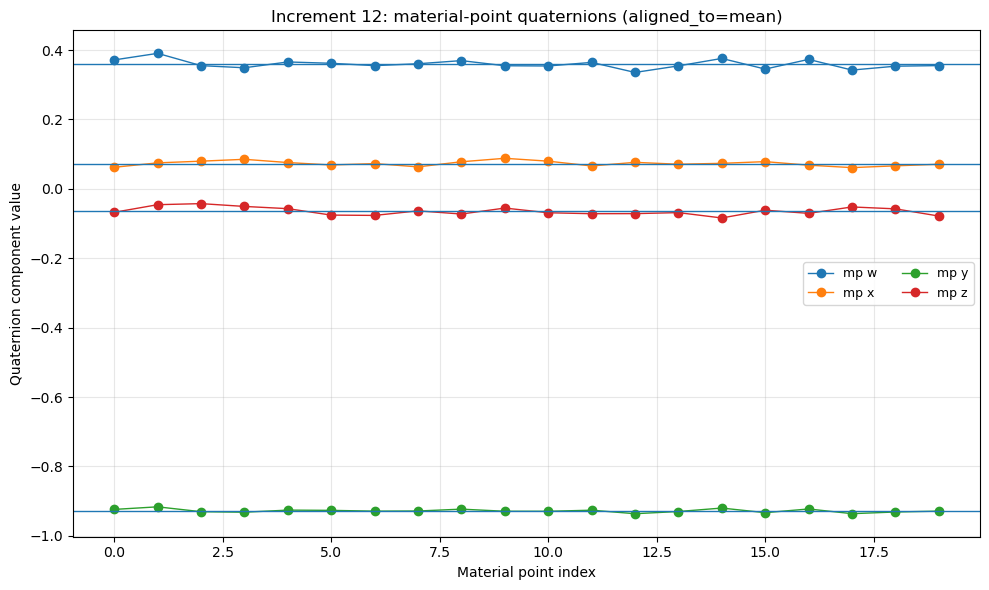

In [73]:
type = "Compression"
# type = "Traction"
direction = "X"
# direction = "XZ"
# direction = "Z"
grain_index = 21

measurement = "for_ML_quaternion_perMatpoint_pergrain"
loadcase = f"{type}{direction}"
filename = (
    PROJECT_ROOT
    / "2D_10%strain_100grains"
    / "results_grain_matpoint"
    / loadcase
    / measurement
    / f"grain_{grain_index}.txt"
)

components, incs, Q = read_increment_component_arrays_multiline(filename)

qM = mean_quaternion_over_matpoints_sum(Q, max_iter=30)

# for i in range(len(Q)):
#     print(f'\nIncrement {i*10}')
#     print(f'Avg orientation: \n{qM[i]}')
#     print(f'Original material points: \n{Q[i]}')

increment = 12
plot_quats_increment(Q, qM, increment)